<h1><center> APS Failure and Operational Data for Scania Trucks </center></h1>

<h1>1. Business Problem</h1>

## 1.1 Description

* Acknowledgement:- This file is part of APS Failure and Operational Data for Scania Trucks. It was imported from the UCI ML Repository.

##### Context
- The system in focus is the <b>Air Pressure system (APS)</b> which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes. The data consists of a subset of all available data, selected by experts.

##### Notation
- The dataset's positive class consists of component failures for a specific component of the APS system.
- The negative class consists of trucks with failures for components not related to the APS.

##### Inspiration

- The total cost of a prediction model the sum of Cost_1 multiplied by the number of Instances with type 1 failure and Cost_2 with the number of instances with type 2 failure, resulting in a Total_cost.


- Cost_1 = The cost that an unnecessary check needs to be done by an mechanic at an workshop
- Cost_2 = The cost of missing a faulty truck, which may cause a breakdown.
<br><br>



     True class |  predicted class  |
                |  neg   |   pos    |
     --------------------------------
      neg       |    -   |  Cost_1  |
     --------------------------------
      pos       | Cost_2 |    -     |
     --------------------------------

<h4>Cost_1 = 10 and Cost_2 = 500 </h4>
<h4>Total_cost = Cost_1*No_Instances + Cost_2*No_Instances.</h4>
<h5>total_cost = False_positive*10 + False_Negative*500 </h5>

#### Attribute Infrmation

- Number of Attributes: 171 

- The attribute names of the data have been anonymized for proprietary reasons. It consists of both single numerical counters and histograms consisting of bins with different conditions. Typically the histograms have open-ended conditions at each end. For example if we measuring the ambient temperature "T" then the histogram could be defined with 4 bins where: 

   - bin 1 collect values for temperature T < -20 <br>
   - bin 2 collect values for temperature T >= -20 and T < 0     
   - bin 3 collect values for temperature T >= 0 and T < 20  
   - bin 4 collect values for temperature T > 20 

- The attributes are as follows: class, then anonymized operational data. The operational data have an identifier and a bin id, like "Identifier_Bin". In total there are 171 attributes, of which 7 are histogram variabels. Missing values are denoted by "na".


<h2>1.2 Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important( as we can see which feature is helpful in detecting failure)
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set
- Train and test data are given separately 


##### Content

- The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record.

- __Note:- There is a Problem of Class Imbalance__


<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are two different classes to be classified into => Binary class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

* total_cost = False_positive x 10 + False_Negative x 500
* ROC-AUC Curve (used to find the total_cost)
* Confusion matrix (helps in getting exact count of wrong predicted class)

# 3. Exploratory Data Analysis 

In [1]:
#import all the necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import math
import plotly
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns
import pickle

from tqdm import tqdm
from collections import Counter
from prettytable import PrettyTable
from plotly.graph_objs import Scatter, Layout
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2

<h3>3.1 Reading Train and Test Data</h3>

In [2]:
train_data = pd.read_csv('aps_failure_training_set.csv', na_values=["na"])
test_data = pd.read_csv('aps_failure_test_set.csv', na_values=["na"])

In [3]:
total_column = train_data.columns.values

In [4]:
print('Number of data points in train_set : ', train_data.shape[0])
print('Number of features in train_set: ', train_data.shape[1])
print()
print('Features : ', train_data.columns.values)
train_data.head()

Number of data points in train_set :  60000
Number of features in train_set:  171

Features :  ['class' 'aa_000' 'ab_000' 'ac_000' 'ad_000' 'ae_000' 'af_000' 'ag_000'
 'ag_001' 'ag_002' 'ag_003' 'ag_004' 'ag_005' 'ag_006' 'ag_007' 'ag_008'
 'ag_009' 'ah_000' 'ai_000' 'aj_000' 'ak_000' 'al_000' 'am_0' 'an_000'
 'ao_000' 'ap_000' 'aq_000' 'ar_000' 'as_000' 'at_000' 'au_000' 'av_000'
 'ax_000' 'ay_000' 'ay_001' 'ay_002' 'ay_003' 'ay_004' 'ay_005' 'ay_006'
 'ay_007' 'ay_008' 'ay_009' 'az_000' 'az_001' 'az_002' 'az_003' 'az_004'
 'az_005' 'az_006' 'az_007' 'az_008' 'az_009' 'ba_000' 'ba_001' 'ba_002'
 'ba_003' 'ba_004' 'ba_005' 'ba_006' 'ba_007' 'ba_008' 'ba_009' 'bb_000'
 'bc_000' 'bd_000' 'be_000' 'bf_000' 'bg_000' 'bh_000' 'bi_000' 'bj_000'
 'bk_000' 'bl_000' 'bm_000' 'bn_000' 'bo_000' 'bp_000' 'bq_000' 'br_000'
 'bs_000' 'bt_000' 'bu_000' 'bv_000' 'bx_000' 'by_000' 'bz_000' 'ca_000'
 'cb_000' 'cc_000' 'cd_000' 'ce_000' 'cf_000' 'cg_000' 'ch_000' 'ci_000'
 'cj_000' 'ck_000' 'cl_000' 'cm_

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [5]:
print('Number of data points in test_set : ', test_data.shape[0])
print('Number of features in test_set: ', test_data.shape[1])
print()
print('Features : ', test_data.columns.values)
test_data.head()

Number of data points in test_set :  16000
Number of features in test_set:  171

Features :  ['class' 'aa_000' 'ab_000' 'ac_000' 'ad_000' 'ae_000' 'af_000' 'ag_000'
 'ag_001' 'ag_002' 'ag_003' 'ag_004' 'ag_005' 'ag_006' 'ag_007' 'ag_008'
 'ag_009' 'ah_000' 'ai_000' 'aj_000' 'ak_000' 'al_000' 'am_0' 'an_000'
 'ao_000' 'ap_000' 'aq_000' 'ar_000' 'as_000' 'at_000' 'au_000' 'av_000'
 'ax_000' 'ay_000' 'ay_001' 'ay_002' 'ay_003' 'ay_004' 'ay_005' 'ay_006'
 'ay_007' 'ay_008' 'ay_009' 'az_000' 'az_001' 'az_002' 'az_003' 'az_004'
 'az_005' 'az_006' 'az_007' 'az_008' 'az_009' 'ba_000' 'ba_001' 'ba_002'
 'ba_003' 'ba_004' 'ba_005' 'ba_006' 'ba_007' 'ba_008' 'ba_009' 'bb_000'
 'bc_000' 'bd_000' 'be_000' 'bf_000' 'bg_000' 'bh_000' 'bi_000' 'bj_000'
 'bk_000' 'bl_000' 'bm_000' 'bn_000' 'bo_000' 'bp_000' 'bq_000' 'br_000'
 'bs_000' 'bt_000' 'bu_000' 'bv_000' 'bx_000' 'by_000' 'bz_000' 'ca_000'
 'cb_000' 'cc_000' 'cd_000' 'ce_000' 'cf_000' 'cg_000' 'ch_000' 'ci_000'
 'cj_000' 'ck_000' 'cl_000' 'cm_00

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


### 3.1.1 Over view of train_data

In [6]:
overview = train_data.describe()
overview

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


In [7]:
overview_col = overview.columns
useless_col = []
for i, val in enumerate(overview.loc['std']):
    if val == 0:
        useless_col.append(overview_col[i])

In [8]:
print(useless_col) # 'cd_000'
# as standard_deviation is zero all values are constant, hence no contribution in deciding the class labels
train_data['cd_000'].describe()

['cd_000']


count      59324.0
mean     1209600.0
std            0.0
min      1209600.0
25%      1209600.0
50%      1209600.0
75%      1209600.0
max      1209600.0
Name: cd_000, dtype: float64

## Observation
- Feature 'cd_000' have standard deviation zero, i.e. all the values are constant
- We drop this feature from our data 

In [9]:
train_data.drop(['cd_000'],axis=1,inplace=True)
test_data.drop(['cd_000'],axis=1,inplace=True)

print("Train Shape:- ",train_data.shape)
print("Test_shape:- ",test_data.shape)

Train Shape:-  (60000, 170)
Test_shape:-  (16000, 170)


### 3.1.2. Histogram and Counter Features

- The Attributes have an identifier and a bin id, like "Identifier_Bin".
- for example we have column name as __"aa_000"__, So __Identifier__ is __"aa"__ and __Bin_id__ is __"000"__.

In [10]:
def get_tag(name):
    '''
        This function take an string and split is with delimeter "_"
        and return the first part of the string.
    '''
    return name.split("_")[0]

all_columns_with_tags = [a for a in train_data.columns if "_" in a] # Selecting columns having "_" in name.
all_tags = [get_tag(a) for a in all_columns_with_tags] # Selecting all Identifier name only ex:- ["aa","ab"....].
unique_col = list(set(all_tags)) # Selecting all unique Identifier. 
col_count = [v for k,v in Counter(all_tags).items()] # Calcution of Count of each unique Identifier.

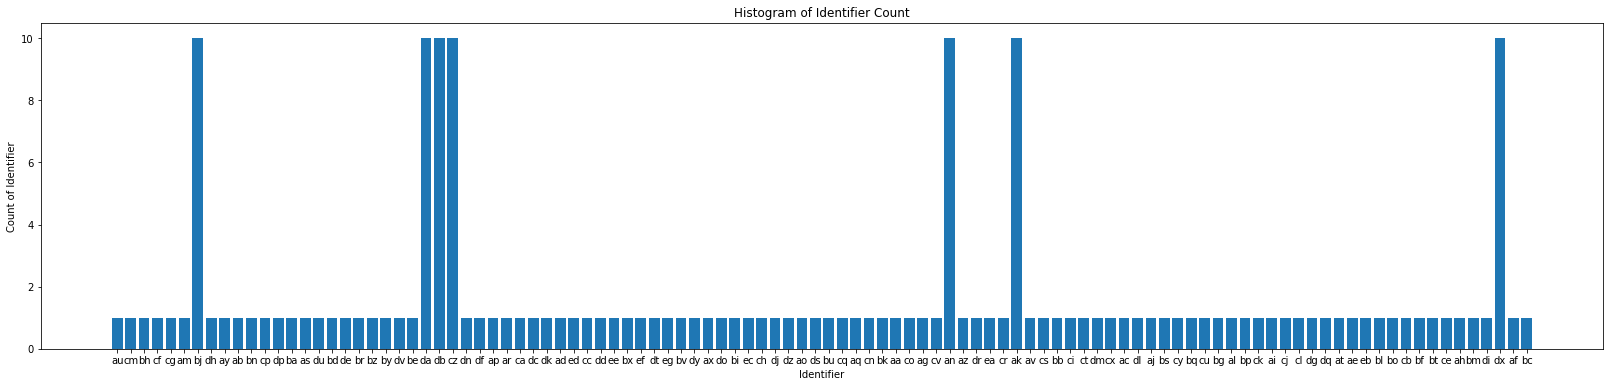

In [11]:
plt.figure(figsize= (28,6))
plt.bar(unique_col,col_count)
plt.xlabel('Identifier')
plt.ylabel('Count of Identifier')
plt.title('Histogram of Identifier Count')
plt.show()

## observation
- 7 Identifier are there with exact count of 10.
- these 7 Identifier are [ag,ay,az,ba,cn,cs,ee]
- These are my histogram attributes, so 7*10 (total 70 attributes), rest are my counter attributes. 

In [12]:
hists = [k for k,v in Counter(all_tags).items() if v == 10] #[ag,ay,az,ba,cn,cs,ee]
hists_columns = [k for k in all_columns_with_tags if get_tag(k) in hists] #[ag_000..ag_009, ay_000..ay_009,..., ee_000...ee_009]
counter_columns = [k for k in all_columns_with_tags if get_tag(k) not in hists]

hists_dict = {k:[col for col in hists_columns if k in col] for k in hists if get_tag(k) in hists}
# {'ag': ['ag_000','ag_001','ag_002','ag_003','ag_004','ag_005','ag_006','ag_007','ag_008','ag_009'],
# ....
#  'ee': ['ee_000','ee_001','ee_002','ee_003','ee_004','ee_005','ee_006','ee_007','ee_008','ee_009']}

In [13]:
extra_data = pd.DataFrame()
for hist in hists:
    extra_data[f"{hist}_total"] = sum(train_data[col] for col in hists_dict[hist])
extra_data.head()

,ag_total,ay_total,az_total,ba_total,cn_total,cs_total,ee_total
0,6167850.0,6167850.0,6167850.0,6167850.0,6167850.0,6167850.0,6167850.0
1,2940714.0,2940714.0,2940714.0,2942850.0,2942850.0,2942850.0,2940714.0
2,2560566.0,2560566.0,2560566.0,2560566.0,2560566.0,2560566.0,2560566.0
3,7634.0,7634.0,7634.0,7634.0,7634.0,7634.0,7634.0
4,3946944.0,3946944.0,3946944.0,3946944.0,3946944.0,3946944.0,3946944.0


### Observation
-  we found almost equal values if we sum all the family of each histogram.
-  Those values which are not equal is due to missing value

In [14]:
# storing only the histogram features
train_hist_df = train_data[hists_columns]
test_hist_df = test_data[hists_columns]


# co-relation matrix for only histogram features
train_corr = train_data[hists_columns].corr()

# dropping histogram features from real data
train_data.drop(hists_columns,axis=1,inplace=True)
test_data.drop(hists_columns,axis=1,inplace=True)

print('After dropping Histogram features---------')

print("Train Shape:- ",train_data.shape)
print("Test_shape:- ",test_data.shape)

print("Shape of train co-relation matrix",train_corr.shape)

After dropping Histogram features---------
Train Shape:-  (60000, 100)
Test_shape:-  (16000, 100)
Shape of train co-relation matrix (70, 70)


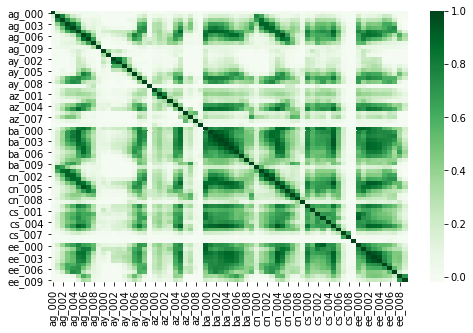

In [15]:
plt.figure(figsize= (8,5))
trace = sns.heatmap(train_corr,cmap=plt.cm.Greens)
plt.show()

## Observation
- some of the features are highly co-related
- We will discard features having correlation value >=0.75

In [16]:
# Dropping columns having correlation >= thres (here thres = 0.75)

def drop_correlated_col(corr_matrix,hist_df, thres):
    '''
        This function will check each value in matrix and return those columns
        which have co-relation value greater than thres.
    '''
    colm = [True for i in range(corr_matrix.shape[0])] # creating an array of size 70 with all value as True

    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[0]):
            if corr_matrix.iloc[i,j] >= thres:
                if colm[j]:
                    colm[j] = False
          
    selected_columns = hist_df.columns[colm]
    return selected_columns

In [17]:
col_to_drop = drop_correlated_col(train_corr,train_hist_df,0.75) # get the columns to drop

train_hist_df = train_hist_df[col_to_drop]
test_hist_df = test_hist_df[col_to_drop]

print("Best Train histogram features",train_hist_df.shape)
print("Best Test histogram features",test_hist_df.shape)

Best Train histogram features (60000, 32)
Best Test histogram features (16000, 32)


- __Out of 70 features we get 32 that is 38 features were dropped.__

In [18]:
# Now we are concatinating our histogram features with rest of features.

train_data = pd.concat([train_data,train_hist_df],axis=1)
test_data = pd.concat([test_data,test_hist_df],axis=1)

print("Train Shape:- ",train_data.shape)
print("Test_shape:- ",test_data.shape)

Train Shape:-  (60000, 132)
Test_shape:-  (16000, 132)


## 3.2 Distribution on class label

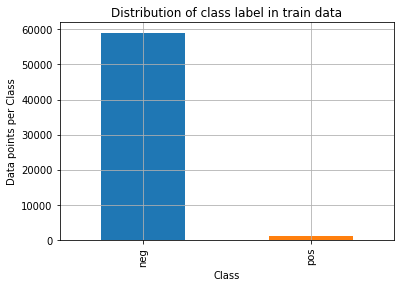

--------OBSERVATION----------

Number of data points in class 1 : 59000 ( 98.333 %)
Number of data points in class 2 : 1000 ( 1.667 %)


In [19]:
train_data_distribution = train_data['class'].value_counts().sortlevel()
train_data_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of class label in train data')
plt.grid()
plt.show()

print("--------OBSERVATION----------")
print()
sorted_yi = np.argsort(-train_data_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_data_distribution.values[i], '(', np.round((train_data_distribution.values[i]/train_data.shape[0]*100), 3), '%)')


## 3.2.1. changing notation

<b>'neg'</b> as <b>0</b>  means Failures not related with APS System  __"No action required in APS"__<br>
<b>'pos'</b> as <b>1</b>  means Failures related with APS System __"Action required in APS"__

In [20]:
# changing notation in train_data
def change_notation(data):
    ''' This Function helps in Changing The class Notation '''
    class_label = []
    for i in data:
        if i == 'neg':
            class_label.append(0)
        else:
            class_label.append(1)
    return class_label

In [21]:
class_train = change_notation(train_data['class'])
train_data.drop(['class'],axis=1,inplace=True)
train_data['class'] = class_train
train_data.head(2)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ah_000,ai_000,aj_000,ak_000,...,ba_009,cn_009,cs_001,cs_006,cs_007,cs_008,cs_009,ee_008,ee_009,class
0,76698,NaN,2.130706e+09,280.0,0.0,0.0,2551696.0,0.0,0.0,0.0,...,0.0,1608.0,1226.0,895240.0,26330.0,118.0,0.0,73224.0,0.0,0
1,33058,NaN,0.000000e+00,NaN,0.0,0.0,1393352.0,0.0,68.0,0.0,...,4708.0,56.0,796.0,301242.0,9148.0,22.0,0.0,97576.0,1500.0,0


In [22]:
class_test = change_notation(test_data['class'])
test_data.drop(['class'],axis=1,inplace=True)
test_data['class'] = class_test
test_data.head(2)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ah_000,ai_000,aj_000,ak_000,...,ba_009,cn_009,cs_001,cs_006,cs_007,cs_008,cs_009,ee_008,ee_009,class
0,60,0.0,20.0,12.0,0.0,0.0,3976.0,0.0,0.0,0.0,...,0.0,0.0,14.0,7650.0,2294.0,206.0,0.0,0.0,0.0,0
1,82,0.0,68.0,40.0,0.0,0.0,5244.0,0.0,60.0,0.0,...,128.0,0.0,28.0,9622.0,2174.0,80.0,0.0,0.0,0.0,0


In [23]:
y_trn = train_data['class']
y_test = test_data['class']
train_data.drop(['class'],axis=1,inplace=True)
test_data.drop(['class'],axis=1,inplace=True)

print('After dropping feature "class"---------')
print("Train Shape:- ",train_data.shape)
print("Test_shape:- ",test_data.shape)

After dropping feature "class"---------
Train Shape:-  (60000, 131)
Test_shape:-  (16000, 131)


## 3.3. Checking The Null values in train and test data

In [24]:
# Checking Which features have no missing value

for i in train_data.isnull().sum():
    if i == 0:
        print(train_data.columns[i])


aa_000


Only column "aa_000" has no missing value 

In [25]:
def calculate_miss_ratio(data):
    
    ''' This function plot the null ratio in descending order
        and it return a dictionary with key as column and 
        value as percentage of missing value in that column.
    '''
    col = data.columns
    miss_ratio = (data.isnull().sum() / data.shape[0]) # calculation of miss_ratio for all the columns
    miss_ratio_sort = miss_ratio.sort_values(ascending=False) # sorting miss_ratio in descending order
    
    # plotting the bar_graph of miss_ratio
    plt.figure(figsize= (25,5))
    miss_ratio_sort.plot(kind='bar')
    plt.xlabel('columns')
    plt.ylabel('Ratio of missing values')
    plt.title('Missing values in data')
    plt.show()
    print("Total columns containing Missing Values are:-",len(miss_ratio_sort))
    
    return dict(zip(col,round(miss_ratio*100,2)))

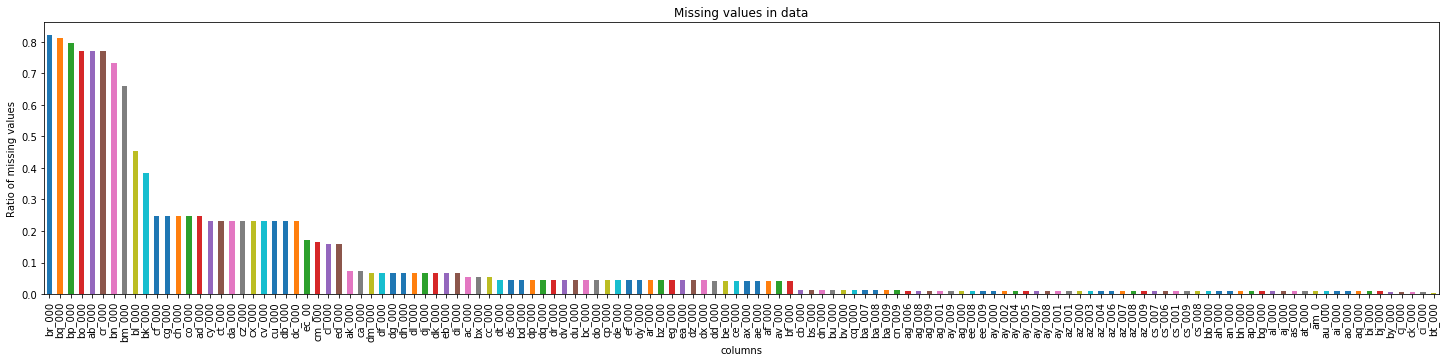

Total columns containing Missing Values are:- 130


In [26]:
# sending data after removal of "aa_000" column as it has no missing value
miss_ratio = calculate_miss_ratio(train_data[train_data.columns.difference(["aa_000"])])  

### Observation
 - There are lot of null values
 - After observing plot we can divide null values into three categories
     - columns which have null_val > 30% 
     - columns which have 30% > null_val > 10%
     - columns which have null_val < 10%

#### Strategy

 - columns which have null_val > 30% 
     - We will __drop__ those columns and __will not__ keep track of those columns. 
 - columns which have 30% > null_val > 10%
     - __median_imputation__ and we will __keep track__ of null_val by making __separate features.__
 - columns which have null_val < 10% 
     - __median_imputation__ and we will __not keep track__ of null_val


### 3.3.1 Dropping and Creating new features

In [27]:
def drop_and_new_features(data,miss_ratio):
    '''
        This function will drop those columns which have missing ratio > 30%
        and create new features as DataFrame with column as new features name
        which contains binary value where 0 = data not missing and 
        1 = data is missing for columns having 30% >= missing ratio >= 10% 
    '''
    new_features = pd.DataFrame()
    drop_features_list = []
    new_features_list = []
    count_new_features = 0
    drop_features = 0
    for idx,val in miss_ratio.items():
        if val > 30:
            data.drop(idx, inplace=True, axis=1)
            drop_features_list.append(idx)
            drop_features += 1
        if val <= 30 and val >= 10:
            count_new_features += 1
            new_idx = idx + '_new'
            new_features_list.append(new_idx)
            new_features[new_idx] = [1 if math.isnan(a) else 0 for a in data[idx]]
            
    print("Total Features Dropped is:- ",drop_features)
    print("Total Number of new features created is:- ",count_new_features)
    
    return new_features,drop_features_list,new_features_list

In [28]:
new_train_features, drop_features_train, new_features_train = drop_and_new_features(train_data, miss_ratio)
new_test_features, drop_features_test, new_features_test = drop_and_new_features(test_data, miss_ratio)

export_column_new_features = np.save('col_new_features.npy',np.array(new_features_train))

Total Features Dropped is:-  10
Total Number of new features created is:-  18
Total Features Dropped is:-  10
Total Number of new features created is:-  18


In [29]:
# updating counter column after dropping of columns containing null values 
counter_columns = np.setdiff1d(counter_columns,drop_features_train)

export_counter_column = np.save('counter_columns.npy',counter_columns)

### 3.3.2. Creating two separate Set of Data
- __train_data_set1__ is data __without__ new features which i have created by keeping track of missing values
- __train_data_set2__ is data __with__ new features which i have created by keeping track of missing values

In [30]:
# set1
train_data_set1 = train_data
test_data_set1 = test_data

# set2
train_data_set2 = pd.concat([train_data,new_train_features],axis=1)
test_data_set2 = pd.concat([test_data,new_test_features],axis=1)

In [31]:
print("Train Shape Set1:- ",train_data_set1.shape)
print("Test shape Set1:- ",test_data_set1.shape)

print("---------------------------------------")

print("Train Shape Set2:- ",train_data_set2.shape)
print("Test shape Set2:- ",test_data_set2.shape)

Train Shape Set1:-  (60000, 121)
Test shape Set1:-  (16000, 121)
---------------------------------------
Train Shape Set2:-  (60000, 139)
Test shape Set2:-  (16000, 139)


##  3.4 Preprocessing (Set 1)

### 3.4.1. Splitting of train Data

In [32]:
train, cv, y_train, y_cv = train_test_split(train_data_set1, y_trn, test_size=0.20, stratify=y_trn)

In [33]:
export_x_train_raw_set1 = np.save('train_raw_set1.npy',train)

In [34]:
print("Train Shape:- ",train.shape,y_train.shape)
print("CV Shape:- ",cv.shape,y_cv.shape)
print("Test Shape:- ",test_data_set1.shape,y_test.shape)

Train Shape:-  (48000, 121) (48000,)
CV Shape:-  (12000, 121) (12000,)
Test Shape:-  (16000, 121) (16000,)


### 3.4.2. Distribution of Class_label

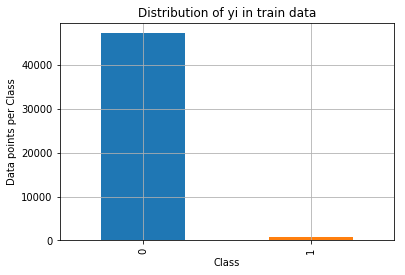

Number of data points in class 1 : 47200 ( 98.333 %)
Number of data points in class 2 : 800 ( 1.667 %)
--------------------------------------------------------------------------------


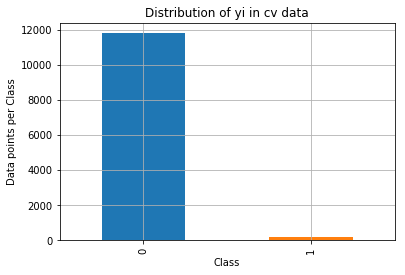

Number of data points in class 1 : 11800 ( 98.333 %)
Number of data points in class 2 : 200 ( 1.667 %)
--------------------------------------------------------------------------------


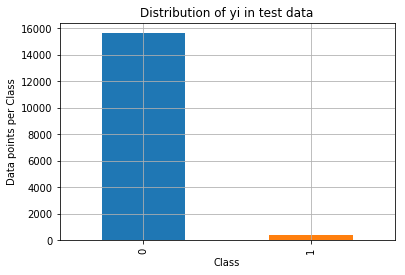

Number of data points in class 1 : 15625 ( 97.656 %)
Number of data points in class 2 : 375 ( 2.344 %)


In [35]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts().sortlevel()
cv_class_distribution = y_cv.value_counts().sortlevel()
test_class_distribution = y_test.value_counts().sortlevel()

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train.shape[0]*100), 3), '%)')

print('-'*80)
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv.shape[0]*100), 3), '%)')

    
    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_data_set1.shape[0]*100), 3), '%)')


##### Distribution of class label is almost same for train and test

- There is a problem of Class Imbalance

### 3.4.3. Imputing missing values

In [36]:
col_lt_30 = [idx for idx,val in miss_ratio.items() if val <= 30 and val > 0 ]

export_col_lt_30 = np.save('col_lt_30.npy',np.array(col_lt_30))

column_set1 = col_lt_30

In [37]:
column_new_feature = [idx for idx,val in miss_ratio.items() if val <= 30 and val >= 10 ]
export_column_new_feature = np.save('column_new_feature.npy',np.array(column_new_feature))

In [38]:
# median Imputation for missing_val <= 30%

imp = SimpleImputer(missing_values=np.nan, strategy='median')

imp.fit(train[col_lt_30])

train_lt_30 = imp.transform(train[col_lt_30])
cv_lt_30 = imp.transform(cv[col_lt_30])
test_lt_30 = imp.transform(test_data_set1[col_lt_30])

#dropping the features
train.drop(col_lt_30, axis=1, inplace=True)
cv.drop(col_lt_30, axis=1, inplace=True)
test_data_set1.drop(col_lt_30, axis=1, inplace=True)

### 3.4.4. concatenating all data together

In [39]:
col = list(train.columns)
column_set1 = column_set1 + col
print("Length Of columns is :- ",len(column_set1))

export_column_set1 = np.save('column_set1.npy',np.array(column_set1))

# total column to drop
column_to_drop = np.setdiff1d(total_column,np.array(column_set1))
export_column_to_drop = np.save('column_to_drop.npy',np.array(column_to_drop))

Length Of columns is :-  121


In [40]:
train = np.hstack((train_lt_30,train))
cv = np.hstack((cv_lt_30,cv))
test = np.hstack((test_lt_30,test_data_set1))

In [41]:
print("Train Shape:- ",train.shape,y_train.shape)
print("CV Shape:- ",cv.shape,y_cv.shape)
print("Test Shape:- ",test.shape,y_test.shape)

Train Shape:-  (48000, 121) (48000,)
CV Shape:-  (12000, 121) (12000,)
Test Shape:-  (16000, 121) (16000,)


### 3.4.5. Normalizing the whole data (MinMaxScaler)

In [42]:
scaler = MinMaxScaler()
x_train_set1 = pd.DataFrame(scaler.fit_transform(train),columns=column_set1)
x_cv_set1 = pd.DataFrame(scaler.transform(cv),columns=column_set1)
x_test_set1 = pd.DataFrame(scaler.transform(test),columns=column_set1)

In [43]:
print("Train Shape:- ",x_train_set1.shape,y_train.shape)
print("CV Shape:- ",x_cv_set1.shape,y_cv.shape)
print("Test Shape:- ",x_test_set1.shape,y_test.shape)

Train Shape:-  (48000, 121) (48000,)
CV Shape:-  (12000, 121) (12000,)
Test Shape:-  (16000, 121) (16000,)


## 3.5. Saving the data

In [44]:
# saving
export_x_train_set1 = np.save('x_train_set1.npy',x_train_set1)
export_x_cv_set1 = np.save('x_cv_set1.npy',x_cv_set1)
export_x_test_set1 = np.save('x_test_set1.npy',x_test_set1)
export_y_train = np.save('y_train_set1.npy',y_train)
export_y_cv = np.save('y_cv_set1.npy',y_cv)
export_y_test = np.save('y_test_set1.npy',np.array(y_test))


In [45]:
# loading
column_set1 = np.load("column_set1.npy")

x_train_set1 = pd.DataFrame(np.load('x_train_set1.npy'),columns=column_set1)
x_cv_set1 = pd.DataFrame(np.load('x_cv_set1.npy'),columns=column_set1)
x_test_set1 = pd.DataFrame(np.load('x_test_set1.npy'),columns=column_set1)
y_train_set1 = np.load('y_train_set1.npy')
y_cv_set1 = np.load('y_cv_set1.npy')
y_test_set1 = np.load('y_test_set1.npy')

## 3.6. Total Cost

In [46]:
def total_cost(matrix):
    '''return the total cost of the model'''
    FP = matrix[0][1]
    FN = matrix[1][0]
    return FP*10 + FN*500

## 4.  Applying ML Algoritms Set1

### 4.1. KNN (Baseline Model)

### 4.1.1 Hyperparameter Tuning

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [14:22<00:00, 96.56s/it]


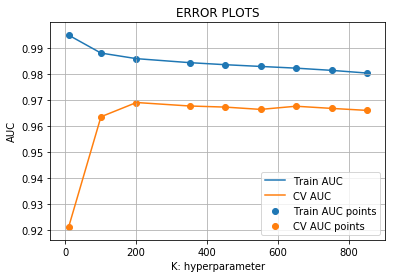

In [4]:
train_auc = []
cv_auc = []
K = [10,101,201,351,451,551,651,751,851]
for i in tqdm(K):
    clf = KNeighborsClassifier(n_neighbors=i,algorithm = 'brute',n_jobs = -1)
    clf.fit(x_train_set1, y_train_set1)

    y_train_pred = clf.predict_proba(x_train_set1)[:,1]  
    y_cv_pred = clf.predict_proba(x_cv_set1)[:,1] 

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train_set1,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_set1, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Summary
 - k = 651 is the best K which we can take for evaluation
 - the separation between cv_auc and train_auc is minimum


### 4.1.2. Tuning Best Threshold Value using CV data

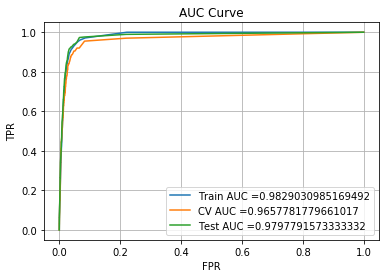

In [47]:
knn_clf = KNeighborsClassifier(n_neighbors=651,algorithm = 'brute',n_jobs = -1)
knn_clf.fit(x_train_set1, y_train_set1)

y_train_pred = knn_clf.predict_proba(x_train_set1)[:,1] 
y_cv_pred = knn_clf.predict_proba(x_cv_set1)[:,1]
y_test_pred = knn_clf.predict_proba(x_test_set1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set1, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set1, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set1, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

In [48]:
def plot_confusion_matrix(matrix):
    '''
        This function takes a 2D and convert it into 2D Heatmap i.e. our confusion matrix 
    '''
    labels = [0,1]
    print()
    print()
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(4,3))
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    return matrix

In [49]:
def total_cost_per_threshold(tpr,fpr,thres,total_pos,total_neg):
    '''
        This function calculate total cost for each threshold and stores the 
        best (tpr,fpr,threshold) which gives lower total_cost.
        
        It also find the confusion matrix from best (tpr, fpr).
        It returns (best_tpr,best_fpr,best_threshold) for which we get minimum
        total_cost.
    '''
    
    cost_per_thres = []
    pre_cost = 99999999;
    
    for i in range(len(tpr)):
        tp = tpr[i]*total_pos #true_positive
        fp = fpr[i]*total_neg #false_positive
        fn = total_pos - tp #false_negative
        cost = fp*10 + fn*500
        cost_per_thres.append(cost)
        
        # storing the best tpr, fpr and threshold value 
        if cost < pre_cost:
            pre_cost = cost
            best_tpr = tpr[i]
            best_fpr = fpr[i]
            best_thres = thres[i]
            index_tr = i
    
    # plotting curve of threshold vs total cost 
    
    plt.plot(thres,cost_per_thres)
    plt.xlabel('Threshold')
    plt.ylabel('Total Cost')
    plt.title("threshold vs total cost")
    plt.grid()
    plt.show()
    
    print("Best tpr from train data: ",best_tpr)
    print("Best fpr from train data: ",best_fpr)
    print("Best Threshold on which we get minimum cost is: ",best_thres)
    
    return best_thres

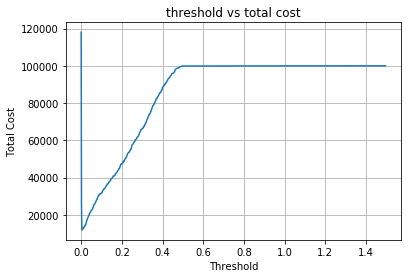

Best tpr from train data:  0.96
Best fpr from train data:  0.06728813559322033
Best Threshold on which we get minimum cost is:  0.004608294930875576


In [50]:
# Finding best train_fpr, train_tpr on cv_data
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 4.1.3. Finding the best cost on CV and Test Data

In [51]:
def predict(proba, threshold):
    '''
    This function take probabilities and threshold and 
    return the actual predicted class labels
    '''
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions  

CV Data


-------------------- Confusion matrix --------------------


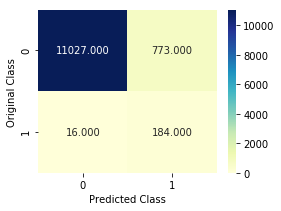

Total CV cost is :  15730


In [52]:
print("CV Data")
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set1,predict(y_cv_pred,best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


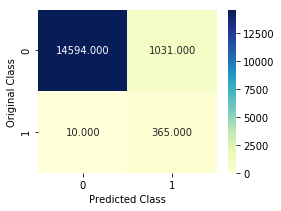

Total Test cost is :  15310


In [53]:
print("Test Data")
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set1,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

## 4.2 Logistic Regression

### 4.2.1. Hyperparameter Tuning

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  5.05s/it]


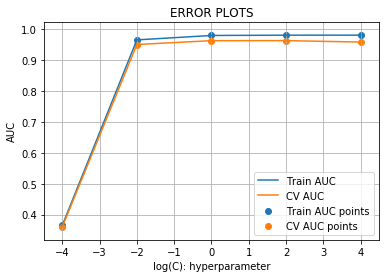

In [54]:
train_auc = []
cv_auc = []

a = [10**-4, 10**-2, 10**0, 10**2 ,10**4]
b = [math.log(i,10) for i in a]
for i in tqdm(a):
    lr = LogisticRegression(C=i)
    lr.fit(x_train_set1, y_train_set1)

    y_train_pred = lr.predict_proba(x_train_set1)[:,1]     
    y_cv_pred = lr.predict_proba(x_cv_set1)[:,1] 

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train_set1,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_set1, y_cv_pred))
plt.plot(b, train_auc, label='Train AUC')
plt.plot(b, cv_auc, label='CV AUC')

plt.scatter(b, train_auc, label='Train AUC points')
plt.scatter(b, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Summary
 - C = 1 is the best C which we can take for evaluation
 - the separation between cv_auc and train_auc is minimum


### 4.2.2. Tuning Best Threshold Value using CV data

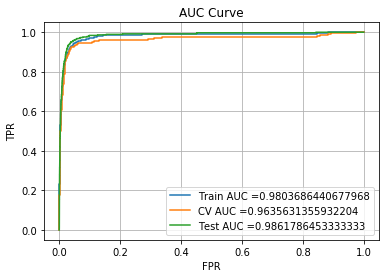

In [62]:
lr_clf = LogisticRegression(C=1)
lr_clf.fit(x_train_set1, y_train_set1)

y_train_pred = lr_clf.predict_proba(x_train_set1)[:,1] 
y_cv_pred = lr_clf.predict_proba(x_cv_set1)[:,1]
y_test_pred = lr_clf.predict_proba(x_test_set1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set1, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set1, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set1, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

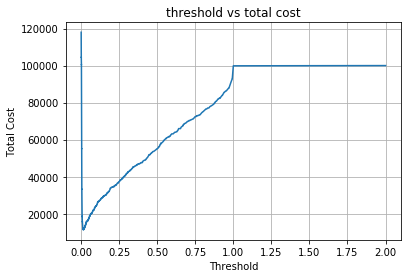

Best tpr from train data:  0.945
Best fpr from train data:  0.04877118644067797
Best Threshold on which we get minimum cost is:  0.014787610305268149


In [63]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 4.2.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


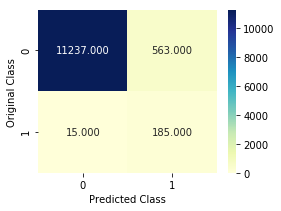

Total CV cost is :  13130


In [64]:
print("CV Data")
y_cv_pred_lr = predict(y_cv_pred, best_train_threshold)
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set1,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


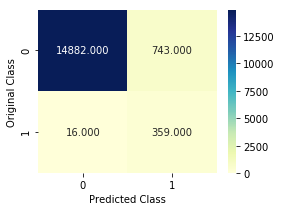

Total Test cost is :  15430


In [65]:
print("Test Data")
y_test_pred_lr = predict(y_test_pred, best_train_threshold)
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set1,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

### 4.3 Random Forest

### 4.3.1 Hyperparameter Tuning

In [66]:
n_estimators = [100,200,500,1000]
max_depth = [3,5,10,20]

train_auc = []
cv_auc = []

for estimator in n_estimators:
    temp_tr = []
    temp_cv = []
    for depth in max_depth:
        clf=RandomForestClassifier(n_estimators =estimator ,max_depth = depth,n_jobs=-1)
        clf.fit(x_train_set1,y_train_set1)
        
        y_train_pred = clf.predict_proba(x_train_set1)[:,1]    
        y_cv_pred = clf.predict_proba(x_cv_set1)[:,1]
    
        temp_tr.append(roc_auc_score(y_train_set1,y_train_pred))
        temp_cv.append(roc_auc_score(y_cv_set1, y_cv_pred))
        
    train_auc.append(temp_tr)
    cv_auc.append(temp_cv)

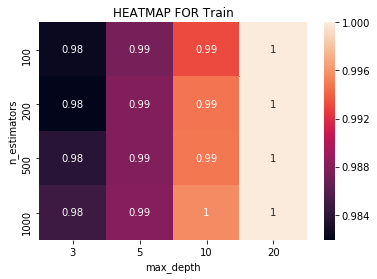

In [67]:
sns.heatmap(train_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR Train")
plt.show()

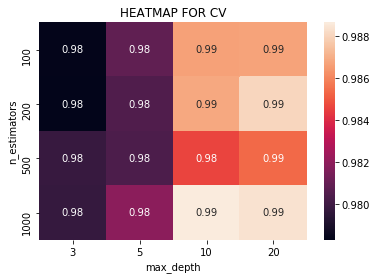

In [68]:
sns.heatmap(cv_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR CV")
plt.show()

### Summary
 - n_estimators = 1000 and max_depth = 10 
 - 0.99 is the max value and the box with the lightest color is selected

### 4.3.2. Hyperparameter Tuning for fpr and tpr

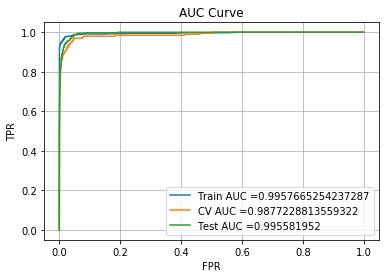

In [69]:
rnd_clf =RandomForestClassifier(n_estimators =1000 ,max_depth = 10,n_jobs=-1)
rnd_clf.fit(x_train_set1,y_train_set1)

y_train_pred = rnd_clf.predict_proba(x_train_set1)[:,1] 
y_cv_pred = rnd_clf.predict_proba(x_cv_set1)[:,1]
y_test_pred = rnd_clf.predict_proba(x_test_set1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set1, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set1, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set1, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

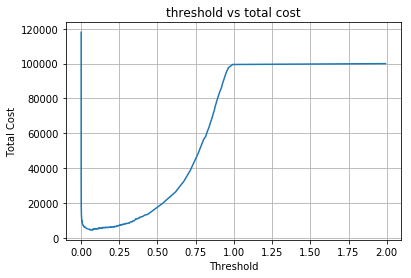

Best tpr from train data:  0.97625
Best fpr from train data:  0.018771186440677965
Best Threshold on which we get minimum cost is:  0.0715252522274537


In [70]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 4.3.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


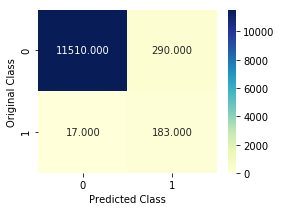

Total CV cost is :  11400


In [71]:
print("CV Data")
y_cv_pred_rnd = predict(y_cv_pred, best_train_threshold)
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set1,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


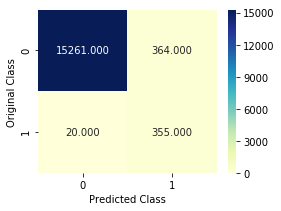

Total Test cost is :  13640


In [72]:
print("Test Data")
y_test_pred_rnd = predict(y_test_pred, best_train_threshold)
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set1,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

### 4.4. Xgboost

### 4.4.1 Hyperparameter Tuning

In [73]:
n_estimators = [100,200,500,1000]
max_depth = [3,5,10,20]

train_auc = []
cv_auc = []

for estimator in n_estimators:
    temp_tr = []
    temp_cv = []
    for depth in max_depth:
        clf=XGBClassifier(n_estimators =estimator ,max_depth = depth,n_jobs=-1)
        clf.fit(x_train_set1,y_train_set1)
        
        y_train_pred = clf.predict_proba(x_train_set1)[:,1]    
        y_cv_pred = clf.predict_proba(x_cv_set1)[:,1]
    
        temp_tr.append(roc_auc_score(y_train_set1,y_train_pred))
        temp_cv.append(roc_auc_score(y_cv_set1, y_cv_pred))
        
    train_auc.append(temp_tr)
    cv_auc.append(temp_cv)

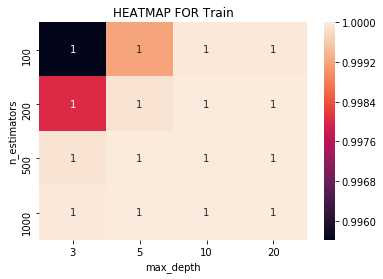

In [74]:
sns.heatmap(train_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR Train")
plt.show()

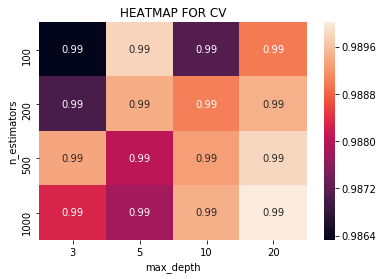

In [75]:
sns.heatmap(cv_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR CV")
plt.show()

### Summary
 - n_estimators = 100 and max_depth = 5
 - 0.99 is the max value and the box with the lightest color is selected

### 4.4.2 Hyperparameter Tuning for fpr and tpr

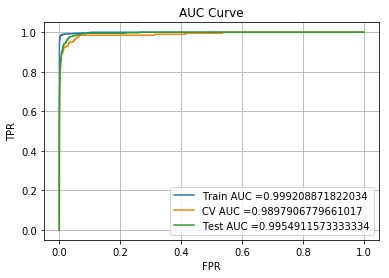

In [80]:
xgb_clf =XGBClassifier(n_estimators =100 ,max_depth = 5,n_jobs=-1)
xgb_clf.fit(x_train_set1,y_train_set1)

y_train_pred = xgb_clf.predict_proba(x_train_set1)[:,1] 
y_cv_pred = xgb_clf.predict_proba(x_cv_set1)[:,1]
y_test_pred = xgb_clf.predict_proba(x_test_set1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set1, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set1, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set1, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

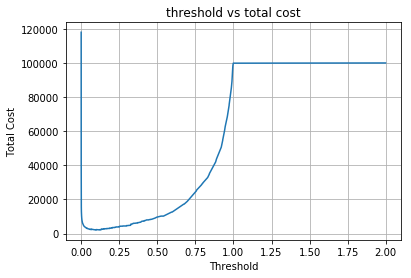

Best tpr from train data:  0.98625
Best fpr from train data:  0.006716101694915254
Best Threshold on which we get minimum cost is:  0.09486727


In [81]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 4.4.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


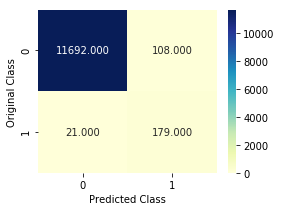

Total CV cost is :  11580


In [82]:
print("CV Data")
y_cv_pred_xgb = predict(y_cv_pred, best_train_threshold)
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set1,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


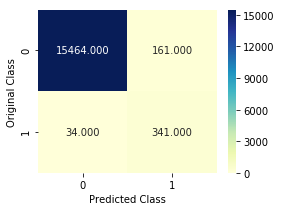

Total Test cost is :  18610


In [83]:
print("Test Data")
y_test_pred_xgb = predict(y_test_pred, best_train_threshold)
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set1,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

In [84]:
best_clf_set1 = rnd_clf

#  5. Preprocessing (Set 2)

### 5.1 Splitting of train Data

In [85]:
train, cv, y_train, y_cv = train_test_split(train_data_set2, y_trn, test_size=0.20, stratify=y_trn)

In [158]:
# exporting Data
export_x_train_raw_set2 = np.save('train_raw_set2.npy',train)
export_raw_set_2 = np.save('column_raw_set2.npy',train_data_set2.columns.values)

In [89]:
print("Train Shape:- ",train.shape,y_train.shape)
print("CV Shape:- ",cv.shape,y_cv.shape)
print("Test Shape:- ",test_data_set2.shape,y_test.shape)

Train Shape:-  (48000, 139) (48000,)
CV Shape:-  (12000, 139) (12000,)
Test Shape:-  (16000, 139) (16000,)


### 5.2. Imputing missing values

In [90]:
col_lt_30 = [idx for idx,val in miss_ratio.items() if val <= 30 and val > 0 ]

column_set2 = col_lt_30

In [91]:
# median Imputation for missing_val <= 30%

imp = SimpleImputer(missing_values=np.nan, strategy='median')

imp.fit(train[col_lt_30])

train_lt_30 = imp.transform(train[col_lt_30])
cv_lt_30 = imp.transform(cv[col_lt_30])
test_lt_30 = imp.transform(test_data_set2[col_lt_30])

#dropping the features
train.drop(col_lt_30, axis=1, inplace=True)
cv.drop(col_lt_30, axis=1, inplace=True)
test_data_set2.drop(col_lt_30, axis=1, inplace=True)

### 5.3. concatenating all data together

In [92]:
col = list(train.columns)
column_set2 = column_set2 + col
print("Length Of columns is :- ",len(column_set2))

export_column_set2 = np.save('column_set2.npy',np.array(column_set2))

Length Of columns is :-  139


In [93]:
train = np.hstack((train_lt_30,train))
cv = np.hstack((cv_lt_30,cv))
test = np.hstack((test_lt_30,test_data_set2))

In [94]:
print("Train Shape:- ",train.shape,y_train.shape)
print("CV Shape:- ",cv.shape,y_cv.shape)
print("Test Shape:- ",test.shape,y_test.shape)

Train Shape:-  (48000, 139) (48000,)
CV Shape:-  (12000, 139) (12000,)
Test Shape:-  (16000, 139) (16000,)


### 5.4. Normalizing the whole data (MinMaxScaler)

In [95]:
scaler = MinMaxScaler()
x_train_set2 = pd.DataFrame(scaler.fit_transform(train),columns=column_set2)
x_cv_set2 = pd.DataFrame(scaler.transform(cv),columns=column_set2)
x_test_set2 = pd.DataFrame(scaler.transform(test),columns=column_set2)

In [96]:
print("Train Shape:- ",x_train_set2.shape,y_train.shape)
print("CV Shape:- ",x_cv_set2.shape,y_cv.shape)
print("Test Shape:- ",x_test_set2.shape,y_test.shape)

Train Shape:-  (48000, 139) (48000,)
CV Shape:-  (12000, 139) (12000,)
Test Shape:-  (16000, 139) (16000,)


### 5.5. Saving Model 

In [97]:
# saving
export_x_train_set2 = np.save('x_train_set2.npy',x_train_set2)
export_x_cv_set2 = np.save('x_cv_set2.npy',x_cv_set2)
export_x_test_set2 = np.save('x_test_set2.npy',x_test_set2)
export_y_train = np.save('y_train_set2.npy',y_train)
export_y_cv = np.save('y_cv_set2.npy',y_cv)
export_y_test = np.save('y_test_set2.npy',np.array(y_test))

In [98]:
# loading
column_set2 = np.load("column_set2.npy")

x_train_set2 = pd.DataFrame(np.load('x_train_set2.npy'),columns=column_set2)
x_cv_set2 = pd.DataFrame(np.load('x_cv_set2.npy'),columns=column_set2)
x_test_set2 = pd.DataFrame(np.load('x_test_set2.npy'),columns=column_set2)
y_train_set2 = np.load('y_train_set2.npy')
y_cv_set2 = np.load('y_cv_set2.npy')
y_test_set2 = np.load('y_test_set2.npy')

# 6. Applying ML models on Set2

## 6.1 Logistic Regression

### 6.1.1. Hyperparameter Tuning

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  7.76s/it]


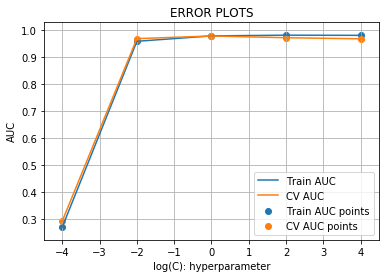

In [99]:
train_auc = []
cv_auc = []

a = [10**-4, 10**-2, 10**0, 10**2 ,10**4]
b = [math.log(i,10) for i in a]
for i in tqdm(a):
    lr = LogisticRegression(C=i)
    lr.fit(x_train_set2, y_train_set2)

    y_train_pred = lr.predict_proba(x_train_set2)[:,1]     
    y_cv_pred = lr.predict_proba(x_cv_set2)[:,1] 

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train_set2,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_set2, y_cv_pred))
plt.plot(b, train_auc, label='Train AUC')
plt.plot(b, cv_auc, label='CV AUC')

plt.scatter(b, train_auc, label='Train AUC points')
plt.scatter(b, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Summary
 - C = 1 is the best C which we can take for evaluation
 - the separation between cv_auc and train_auc is minimum


### 6.1.2. Tuning Best Threshold Value using CV data

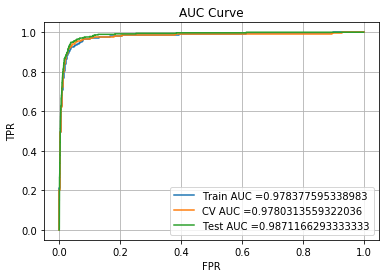

In [100]:
lr_clf = LogisticRegression(C=1)
lr_clf.fit(x_train_set2, y_train_set2)

y_train_pred = lr_clf.predict_proba(x_train_set2)[:,1] 
y_cv_pred = lr_clf.predict_proba(x_cv_set2)[:,1]
y_test_pred = lr_clf.predict_proba(x_test_set2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set2, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set2, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set2, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

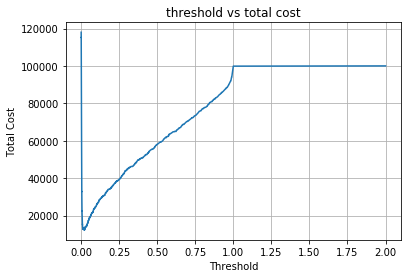

Best tpr from train data:  0.92125
Best fpr from train data:  0.0374364406779661
Best Threshold on which we get minimum cost is:  0.02313502871722956


In [101]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 6.1.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


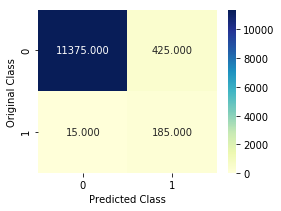

Total CV cost is :  11750


In [102]:
print("CV Data")
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set2,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


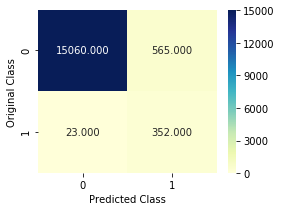

Total Test cost is :  17150


In [103]:
print("Test Data")
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set2,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

### 6.2. Random Forest

### 6.2.1. Hyperparameter Tuning

In [104]:
n_estimators = [100,200,500,1000]
max_depth = [3,5,10,20]

train_auc = []
cv_auc = []

for estimator in n_estimators:
    temp_tr = []
    temp_cv = []
    for depth in max_depth:
        clf=RandomForestClassifier(n_estimators =estimator ,max_depth = depth,n_jobs=-1)
        clf.fit(x_train_set2,y_train_set2)
        
        y_train_pred = clf.predict_proba(x_train_set2)[:,1]    
        y_cv_pred = clf.predict_proba(x_cv_set2)[:,1]
    
        temp_tr.append(roc_auc_score(y_train_set2,y_train_pred))
        temp_cv.append(roc_auc_score(y_cv_set2, y_cv_pred))
        
    train_auc.append(temp_tr)
    cv_auc.append(temp_cv)

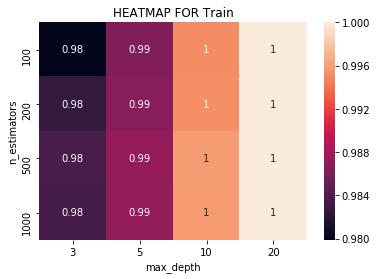

In [105]:
sns.heatmap(train_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR Train")
plt.show()

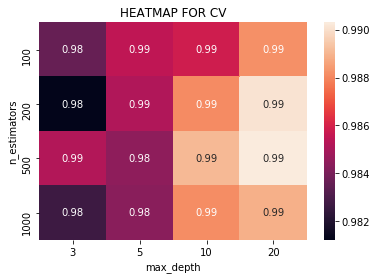

In [106]:
sns.heatmap(cv_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR CV")
plt.show()

### Summary
 - n_estimators = 500 and max_depth = 10 
 - 0.99 is the max value and the box with the ligher color is selected and will be tested

### 6.2.2. Hyperparameter Tuning for fpr and tpr

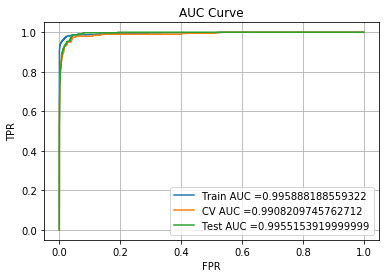

In [115]:
rnd_clf =RandomForestClassifier(n_estimators =500 ,max_depth = 10,n_jobs=-1)
rnd_clf.fit(x_train_set2,y_train_set2)

y_train_pred = rnd_clf.predict_proba(x_train_set2)[:,1] 
y_cv_pred = rnd_clf.predict_proba(x_cv_set2)[:,1]
y_test_pred = rnd_clf.predict_proba(x_test_set2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set2, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set2, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set2, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

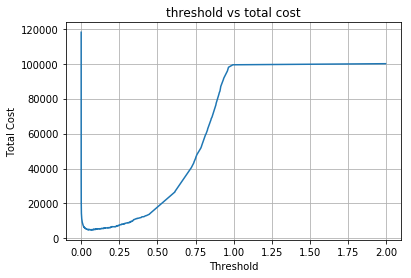

Best tpr from train data:  0.975
Best fpr from train data:  0.020063559322033898
Best Threshold on which we get minimum cost is:  0.0668339064173814


In [116]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 6.2.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


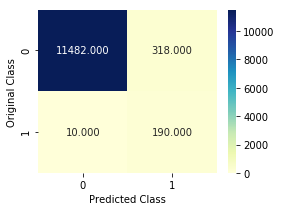

Total CV cost is :  8180


In [117]:
print("CV Data")
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set2,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


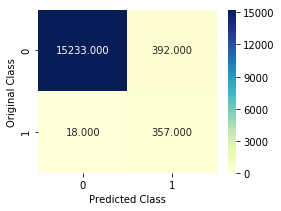

Total Test cost is :  12920


In [118]:
print("Test Data")
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set2,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

### 6.3. Xgboost

### 6.3.1. Hyperparameter Tuning

In [119]:
n_estimators = [100,200,500,1000]
max_depth = [3,5,10,20]

train_auc = []
cv_auc = []

for estimator in n_estimators:
    temp_tr = []
    temp_cv = []
    for depth in max_depth:
        clf=XGBClassifier(n_estimators =estimator ,max_depth = depth,n_jobs=-1)
        clf.fit(x_train_set2,y_train_set2)
        
        y_train_pred = clf.predict_proba(x_train_set2)[:,1]    
        y_cv_pred = clf.predict_proba(x_cv_set2)[:,1]
    
        temp_tr.append(roc_auc_score(y_train_set2,y_train_pred))
        temp_cv.append(roc_auc_score(y_cv_set2, y_cv_pred))
        
    train_auc.append(temp_tr)
    cv_auc.append(temp_cv)

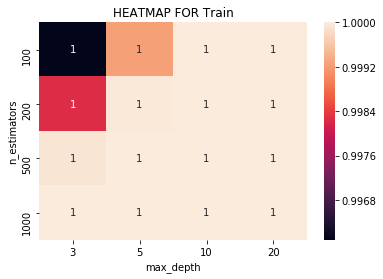

In [120]:
sns.heatmap(train_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR Train")
plt.show()

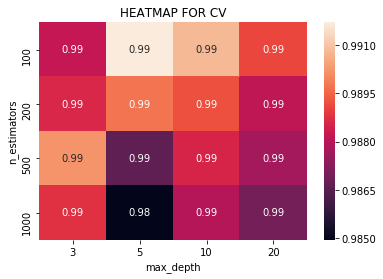

In [121]:
sns.heatmap(cv_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR CV")
plt.show()

### Summary
 - n_estimators = 100 and max_depth = 5
 - 0.99 is the max value and the box with the lightest color is selected

### 6.3.2. Hyperparameter Tuning for fpr and tpr

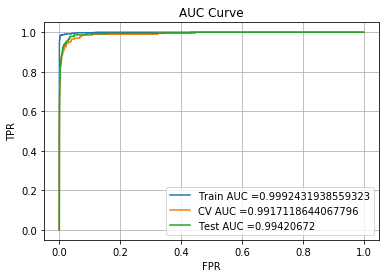

In [122]:
xgb_clf =XGBClassifier(n_estimators =100 ,max_depth = 5,n_jobs=-1)
xgb_clf.fit(x_train_set2,y_train_set2)

y_train_pred = xgb_clf.predict_proba(x_train_set2)[:,1] 
y_cv_pred = xgb_clf.predict_proba(x_cv_set2)[:,1]
y_test_pred = xgb_clf.predict_proba(x_test_set2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set2, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set2, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set2, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

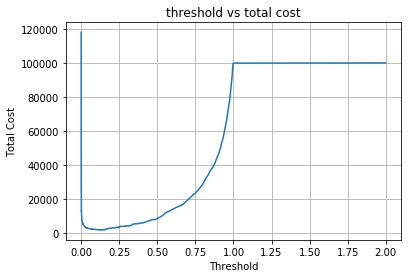

Best tpr from train data:  0.985
Best fpr from train data:  0.0045974576271186444
Best Threshold on which we get minimum cost is:  0.118364476


In [123]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 6.3.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


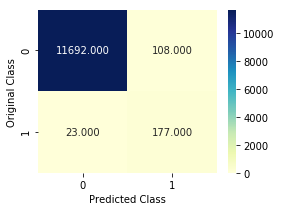

Total CV cost is :  12580


In [124]:
print("CV Data")
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set2,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


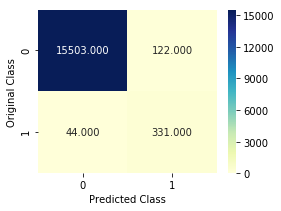

Total Test cost is :  23220


In [125]:
print("Test Data")
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set2,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

In [126]:
best_clf_set2 = rnd_clf

# 7. Applying feature Engineering

- our best clf is random_forest from set2
- we will apply feature_engineering on set2

### 7.1 Selecting best features from Counter features (Select K Best) 

In [127]:
x_train_set1 = pd.DataFrame(np.load('x_train_set1.npy'),columns=column_set1)
x_cv_set1 = pd.DataFrame(np.load('x_cv_set1.npy'),columns=column_set1)
x_test_set1 = pd.DataFrame(np.load('x_test_set1.npy'),columns=column_set1)

In [128]:
# As my counter features contain frequency_data, chi2 is the best parameter for selectKbest

counter_columns = np.load('counter_columns.npy')

counter_df_train = x_train_set2[counter_columns]
counter_df_cv = x_cv_set2[counter_columns]
counter_df_test = x_test_set2[counter_columns]

x_train_set2.drop(counter_columns, axis=1, inplace=True)
x_cv_set2.drop(counter_columns, axis=1, inplace=True)
x_test_set2.drop(counter_columns, axis=1, inplace=True)


print("Shape of Counter Features in Train:- ",counter_df_train.shape)
print("Shape of Counter Features in CV:- ",counter_df_cv.shape)
print("Shape of Counter Features in Test:- ",counter_df_test.shape)

Shape of Counter Features in Train:-  (48000, 89)
Shape of Counter Features in CV:-  (12000, 89)
Shape of Counter Features in Test:-  (16000, 89)


In [129]:
k_best = 70

selectKBest = SelectKBest(chi2, k_best)
selectKBest.fit(counter_df_train, y_train_set2)
best_train_features = selectKBest.transform(counter_df_train)
best_cv_features = selectKBest.transform(counter_df_cv)
best_test_features = selectKBest.transform(counter_df_test)

In [130]:
idxs_selected = selectKBest.get_support(indices=True)
train_features = counter_df_train.iloc[:,idxs_selected]

idxs_selected = selectKBest.get_support(indices=True)
cv_features = counter_df_cv.iloc[:,idxs_selected]

idxs_selected = selectKBest.get_support(indices=True)
test_features = counter_df_test.iloc[:,idxs_selected]

In [131]:
x_train_kbest = pd.concat([x_train_set2,train_features],axis=1)
x_cv_kbest = pd.concat([x_cv_set2,cv_features],axis=1)
x_test_kbest = pd.concat([x_test_set2,test_features],axis=1)

In [132]:
print("Train Shape:- ",x_train_kbest.shape, y_train_set2.shape)
print("CV Shape:- ",x_cv_kbest.shape, y_cv_set2.shape)
print("Test Shape:- ",x_test_kbest.shape, y_test_set2.shape)

Train Shape:-  (48000, 120) (48000,)
CV Shape:-  (12000, 120) (12000,)
Test Shape:-  (16000, 120) (16000,)


## 7.2 Logistic Regression

### 7.2.1. Hyperparameter Tuning

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  5.96s/it]


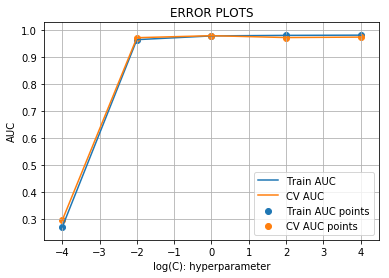

In [133]:
train_auc = []
cv_auc = []

a = [10**-4, 10**-2, 10**0, 10**2,10**4]
b = [math.log(i,10) for i in a]
for i in tqdm(a):
    lr = LogisticRegression(C=i)
    lr.fit(x_train_kbest, y_train_set2)

    y_train_pred = lr.predict_proba(x_train_kbest)[:,1]     
    y_cv_pred = lr.predict_proba(x_cv_kbest)[:,1] 

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train_set2,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_set2, y_cv_pred))
plt.plot(b, train_auc, label='Train AUC')
plt.plot(b, cv_auc, label='CV AUC')

plt.scatter(b, train_auc, label='Train AUC points')
plt.scatter(b, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Summary
 - C = 1 is the best C which we can take for evaluation
 - the separation between cv_auc and train_auc is minimum


### 7.2.2. Tuning Best Threshold Value using CV data

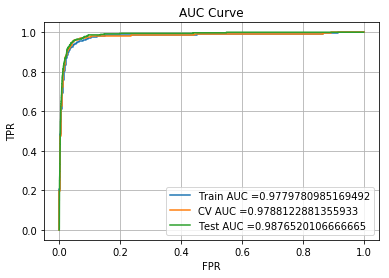

In [134]:
lr_clf = LogisticRegression(C=1)
lr_clf.fit(x_train_kbest, y_train_set2)

y_train_pred = lr_clf.predict_proba(x_train_kbest)[:,1] 
y_cv_pred = lr_clf.predict_proba(x_cv_kbest)[:,1]
y_test_pred = lr_clf.predict_proba(x_test_kbest)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set2, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set2, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set2, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

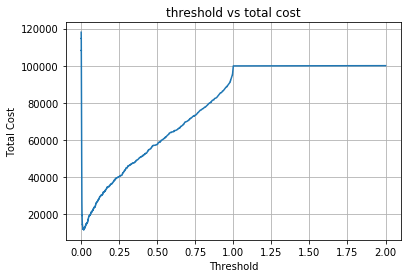

Best tpr from train data:  0.9375
Best fpr from train data:  0.0449364406779661
Best Threshold on which we get minimum cost is:  0.017890063053335393


In [135]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 7.2.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


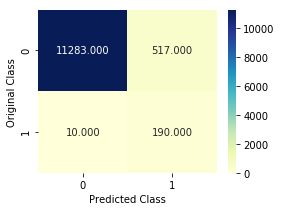

Total CV cost is :  10170


In [136]:
print("CV Data")
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set2,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


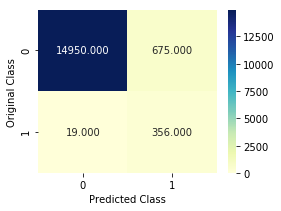

Total Test cost is :  16250


In [137]:
print("Test Data")
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set2,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

## 7.3. Random Forest

### 7.3.1. Hyperparameter Tuning

In [138]:
n_estimators = [100,200,500,1000]
max_depth = [3,5,10,20]

train_auc = []
cv_auc = []

for estimator in n_estimators:
    temp_tr = []
    temp_cv = []
    for depth in max_depth:
        clf=RandomForestClassifier(n_estimators =estimator ,max_depth = depth,n_jobs=-1)
        clf.fit(x_train_kbest,y_train_set2)
        
        y_train_pred = clf.predict_proba(x_train_kbest)[:,1]    
        y_cv_pred = clf.predict_proba(x_cv_kbest)[:,1]
    
        temp_tr.append(roc_auc_score(y_train_set2,y_train_pred))
        temp_cv.append(roc_auc_score(y_cv_set2, y_cv_pred))
        
    train_auc.append(temp_tr)
    cv_auc.append(temp_cv)

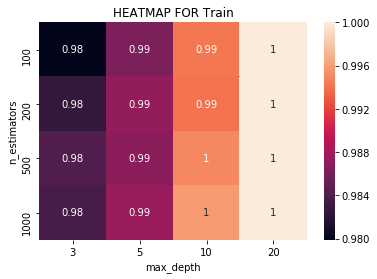

In [139]:
sns.heatmap(train_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR Train")
plt.show()

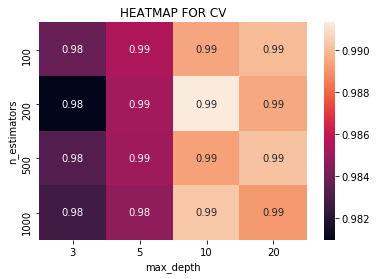

In [140]:
sns.heatmap(cv_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR CV")
plt.show()

### Summary
 - n_estimators = 200 and max_depth = 10
 - 0.99 is the max value and the box with the lightest color is selected

### 7.3.2. Hyperparameter Tuning for tpr and fpr

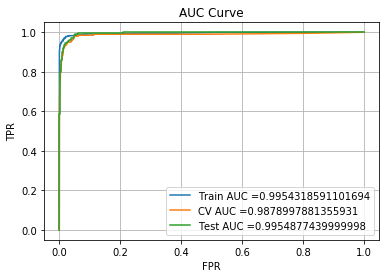

In [141]:
rnd_clf =RandomForestClassifier(n_estimators =200 ,max_depth = 10,n_jobs=-1)
rnd_clf.fit(x_train_kbest,y_train_set2)

y_train_pred = rnd_clf.predict_proba(x_train_kbest)[:,1] 
y_cv_pred = rnd_clf.predict_proba(x_cv_kbest)[:,1]
y_test_pred = rnd_clf.predict_proba(x_test_kbest)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set2, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set2, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set2, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

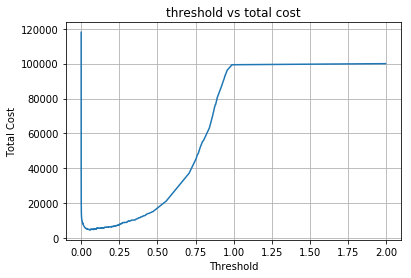

Best tpr from train data:  0.97875
Best fpr from train data:  0.02156779661016949
Best Threshold on which we get minimum cost is:  0.05746496021444489


In [142]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 7.3.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


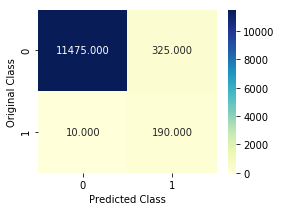

Total CV cost is :  8250


In [143]:
print("CV Data")
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set2,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


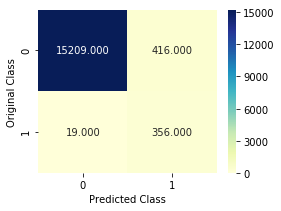

Total Test cost is :  13660


In [144]:
print("Test Data")
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set2,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

## 7.4. Xgboost

### 7.4.1. Hyper Parameter Tuning

In [145]:
n_estimators = [100,200,500,1000]
max_depth = [3,5,10,20]

train_auc = []
cv_auc = []

for estimator in n_estimators:
    temp_tr = []
    temp_cv = []
    for depth in max_depth:
        clf=XGBClassifier(n_estimators =estimator ,max_depth = depth,n_jobs=-1)
        clf.fit(x_train_kbest,y_train_set2)
        
        y_train_pred = clf.predict_proba(x_train_kbest)[:,1]    
        y_cv_pred = clf.predict_proba(x_cv_kbest)[:,1]
    
        temp_tr.append(roc_auc_score(y_train_set2,y_train_pred))
        temp_cv.append(roc_auc_score(y_cv_set2, y_cv_pred))
        
    train_auc.append(temp_tr)
    cv_auc.append(temp_cv)

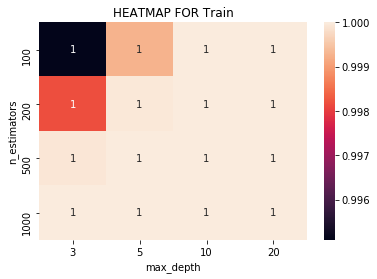

In [146]:
sns.heatmap(train_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR Train")
plt.show()

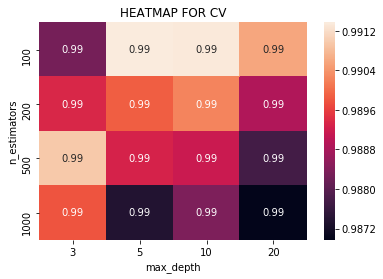

In [147]:
sns.heatmap(cv_auc,annot=True,xticklabels=[3, 5, 10, 20], yticklabels=[100, 200,500, 1000])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("HEATMAP FOR CV")
plt.show()

### Summary
 - n_estimators = 100 and max_depth = 10
 - 0.99 is the max value and the box with the lightest color is selected

### 7.4.2. Hyperparameter tuning for best fpr and tpr

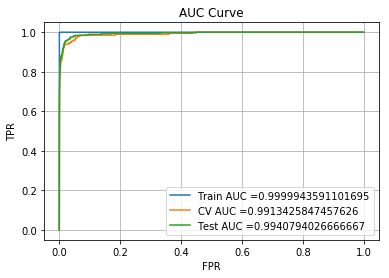

In [149]:
xgb_clf =XGBClassifier(n_estimators =100 ,max_depth = 10,n_jobs=-1)
xgb_clf.fit(x_train_kbest,y_train_set2)

y_train_pred = xgb_clf.predict_proba(x_train_kbest)[:,1] 
y_cv_pred = xgb_clf.predict_proba(x_cv_kbest)[:,1]
y_test_pred = xgb_clf.predict_proba(x_test_kbest)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_set2, y_train_pred)
cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv_set2, y_cv_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_set2, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Curve")
plt.grid()
plt.show()

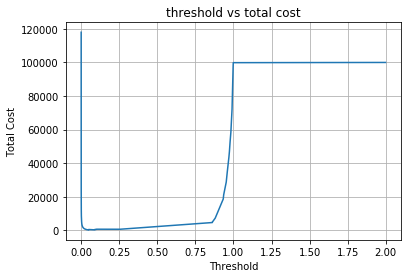

Best tpr from train data:  1.0
Best fpr from train data:  0.0019279661016949152
Best Threshold on which we get minimum cost is:  0.04803474


In [150]:
best_train_threshold = total_cost_per_threshold(train_tpr,train_fpr,tr_thresholds,200,11800)

### 7.4.3. Finding the best cost on CV and Test Data

CV Data


-------------------- Confusion matrix --------------------


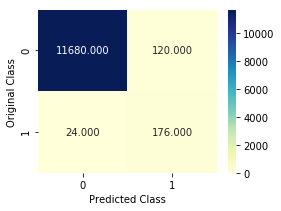

Total CV cost is :  13200


In [151]:
print("CV Data")
cv_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_cv_set2,predict(y_cv_pred, best_train_threshold)))
print("Total CV cost is : ",total_cost(cv_confusion_matrix))

Test Data


-------------------- Confusion matrix --------------------


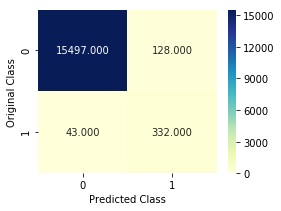

Total Test cost is :  22780


In [152]:
print("Test Data")
test_confusion_matrix = plot_confusion_matrix(confusion_matrix(y_test_set2,predict(y_test_pred,best_train_threshold)))
print("Total Test cost is : ",total_cost(test_confusion_matrix))

## 7.5 Summarizing whole experiment in tabular data

In [153]:
x = PrettyTable()
x.field_names = ["Model","FN_count","FP_count","TotalCost(Test)"]

x.add_row(["-----------SET1-----------","---SET1---","---SET1---",'---SET1---'])
x.add_row(["KNN(Baseline Model)",10,1031,15310])
x.add_row(["Logistic_Regression",16,743,15430])
x.add_row(["Random_Forest",20,364,13640])
x.add_row(["Xgboost",34,161,18610])

x.add_row(["-----------SET2-----------","---SET2---","---SET2---",'---SET2---'])
x.add_row(["Logistic_Regression",23,565,17150])
x.add_row(["Random_Forest",18,392,12920])
x.add_row(["Xgboost",44,122,23220])

x.add_row(["--------SET2-Kbest--------","-SET2-Kbest-","-SET2-Kbest-",'-SET2-Kbest-'])

x.add_row(["Logistic_Regression",19,675,16250])
x.add_row(["Random_Forest",19,416,13660])
x.add_row(["Xgboost",43,128,22780])
print(x)

+----------------------------+--------------+--------------+-----------------+
|           Model            |   FN_count   |   FP_count   | TotalCost(Test) |
+----------------------------+--------------+--------------+-----------------+
| -----------SET1----------- |  ---SET1---  |  ---SET1---  |    ---SET1---   |
|    KNN(Baseline Model)     |      10      |     1031     |      15310      |
|    Logistic_Regression     |      16      |     743      |      15430      |
|       Random_Forest        |      20      |     364      |      13640      |
|          Xgboost           |      34      |     161      |      18610      |
| -----------SET2----------- |  ---SET2---  |  ---SET2---  |    ---SET2---   |
|    Logistic_Regression     |      23      |     565      |      17150      |
|       Random_Forest        |      18      |     392      |      12920      |
|          Xgboost           |      44      |     122      |      23220      |
| --------SET2-Kbest-------- | -SET2-Kbest- | -SET2-

## Observation
 - Minimum Cost is __12920__ using Random_forest From set2 (new_features tracking missing_vals)

## 7.6 Saving The best Model

In [154]:
pickle.dump(best_clf_set2, open('best_model.sav', 'wb'))

## 7.8 Summary

- In EDA, column __"cd_000"__ is found as useless as __standard-deviation is 0__, so all values are constant, dropped this feature.
- Class label notation is changed, __"neg" as 0__ means no action required for APS system and __"pos" as 1__ means action required.
- My data contains two type of features, __histogram features__ and __counter features__ so i separate both of them.
- __Co-relation matrix__ is plotted for __histogram features__ and features with co-relation __val >= 0.75 is dropped__.
- Further, columns were __dropped__ having __missing_ratio > 30%.__
- __New binary features__ were created as missing value tracker for those __columns having "30 >= missing_ratio >=10"__ , where 0 means no_missing_val, 1 means missing_val.
- Two different set of data is created 
        - 1. without new features (missing_val_tracker)
        - 2. with new features (missing_val_tracker)
- __Randomly__ data is separated into __train(80%)__ and __cv(20%)__, labelled test data is already provided.
- For __"30 >= missing_ratio > 0" Median imputation__ was done.
- For __Normalizing__ data __minmaxscaler__ is used.
- Different classifier(KNN, Logistic regression, Random forest, Xgboost) is used, __KNN__ is used as __baseline model.__
- Perfect __threshold__ from train_data is calculated from __AUC curve__. This threshold is used to __predict class label__.
- __Select Kbest__ approach is used for __counter-columns__ with __K= 70.__
- Minimum Cost is __12920__ using __Random_forest__ From set2 (new_features, missing_val_tracker)
